## Week 5 - Lab: EDA Bivariate Analysis

#### Libraries Importation & Dataset Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency


In [2]:
csv_file_path = '/Users/snow/Documents/IRON HACK COURSE/Week 5/Labs/lab-eda-univariate/amz_uk_price_prediction_dataset.csv'
df = pd.read_csv(csv_file_path)
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1 : Analyzing Best-Seller Trends Across Product Categories

#### Objective: Understand the relationship between product categories and their best-seller status

In [3]:
# 1. Crosstab Analysis
# --------------------
# 1.1 Create a crosstab between the product category and the "isBestSeller" status
crosstab = pd.crosstab(df['category'], df['isBestSeller'])
display(crosstab)
print("\n")

# 1.2 Are there categories where being a best-seller is more prevalent
## We can calculate the proportion (2 decimal places) of best-sellers for each category and then sort the categories based on this proportion in descending order
crosstab['proportion'] = crosstab[True] / crosstab.sum(axis=1)
crosstab = crosstab.sort_values('proportion', ascending=False)
crosstab['proportion'] = crosstab['proportion'].round(2)
display(crosstab)
print("\nCategories with a higher proportion of best-sellers may indicate stronger market demand or effective marketing strategies.\n")

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


isBestSeller,False,True,proportion
category,,,
Grocery,9008,556,0.06
Smart Home Security & Lighting,98,6,0.06
Health & Personal Care,9017,552,0.06
Mobile Phone Accessories,248,11,0.04
Power & Hand Tools,8353,306,0.04
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.00
General Music-Making Accessories,259,0,0.00
Snowboard Boots,1449,0,0.00



Categories with a higher proportion of best-sellers may indicate stronger market demand or effective marketing strategies.



In [4]:
# 2. Statistical Tests
# --------------------
# 2.1 Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category
# Create the contingency table
contingency_table = pd.crosstab(df['category'], df['isBestSeller'])

# Perform the Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Display the results
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
if p < 0.05:
    print("Reject the null hypothesis: There is a significant association between product category and best-seller status. \n")
else:
    print("Fail to reject the null hypothesis: No significant association between product category and best-seller status. \n")

# 2.2 Compute Cramér's V to understand the strength of association between best-seller status and category
n = contingency_table.sum().sum()
phi2 = chi2 / n
r, k = contingency_table.shape
cramer_v = np.sqrt(phi2 / min(k - 1, r - 1))
print(f"Cramér's V: {cramer_v}")
if cramer_v < 0.1:
    print("Weak association between product category and best-seller status.\n")
elif 0.1 <= cramer_v < 0.3:
    print("Moderate association between product category and best-seller status.\n")
else:
    print("Strong association between product category and best-seller status.\n")

Chi2 Statistic: 36540.20270061387
P-value: 0.0
Reject the null hypothesis: There is a significant association between product category and best-seller status. 

Cramér's V: 0.1222829439760564
Moderate association between product category and best-seller status.



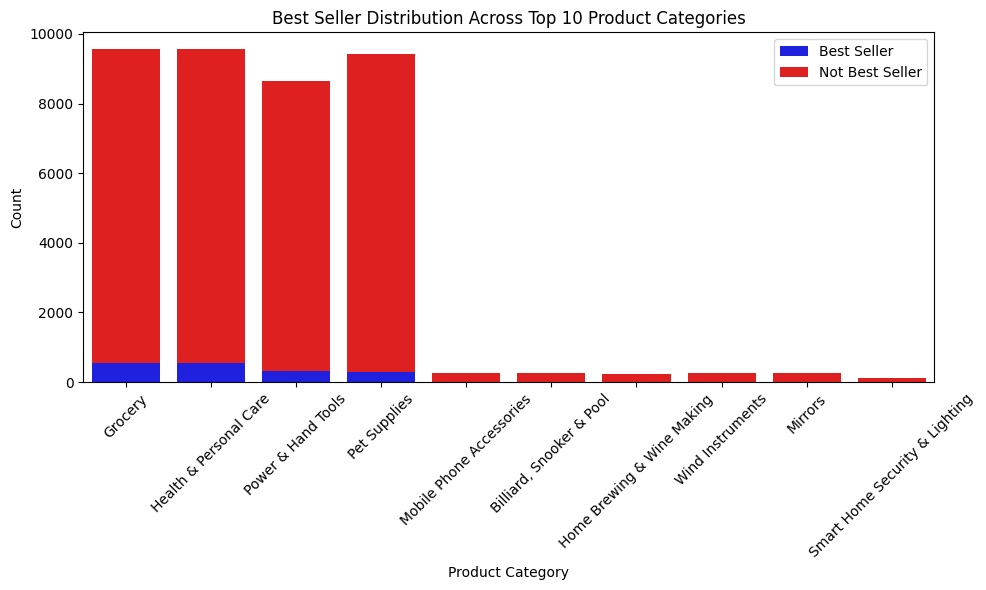

In [5]:
# 3. Visualization
# --------------------
# Stacked Bar Plot
top_10_categories = crosstab.head(10).sort_values(by=True, ascending=False).reset_index()
    
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y=True, data=top_10_categories, color='b', label='Best Seller')
sns.barplot(x='category', y=False, data=top_10_categories, color='r', label='Not Best Seller', bottom=top_10_categories[True])
plt.xticks(rotation=45)
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Best Seller Distribution Across Top 10 Product Categories')
plt.legend()
plt.tight_layout()
plt.show()



### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

#### Objective: Investigate how different product categories influence product prices

In [6]:
# 0. Preliminary Step: Remove outliers in product prices
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

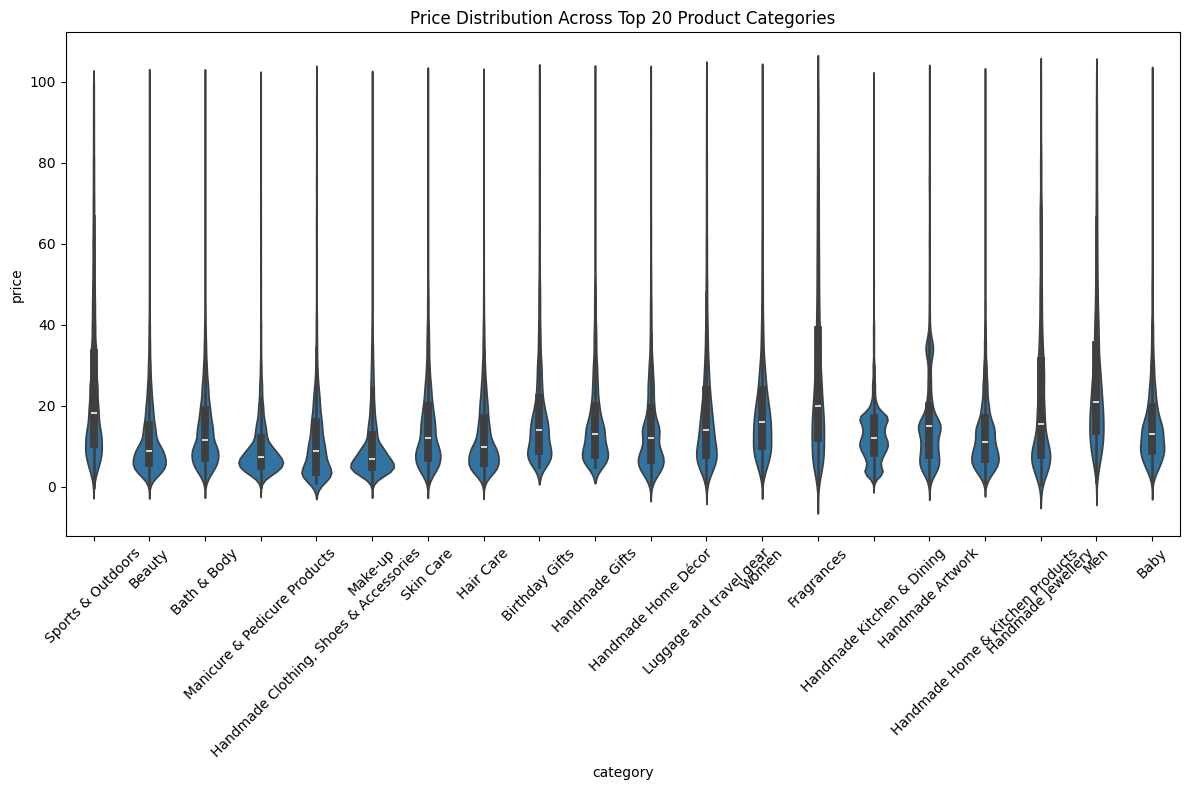

category    Desktop PCs
price              74.0
Name: 75, dtype: object

Category with highest median price: Desktop PCs with median price of 74.0



In [7]:
# 1. Violin Plots
# --------------------
# 1.1 Use a violin plot to visualize the distribution of price across different product categories (Filter out the top 20 categories based on count for better visualization)
top_20_categories = df_filtered['category'].value_counts().nlargest(20).reset_index(name='count')
plt.figure(figsize=(12, 8))
sns.violinplot(x='category', y='price',
			   data=df_filtered[df_filtered['category'].isin(top_20_categories['category'])],
			   order=top_20_categories['category'])
plt.xticks(rotation=45)
plt.title('Price Distribution Across Top 20 Product Categories')
plt.tight_layout()
plt.show()

# 1.2 Which product category tends to have the highest median price? Don't filter here by top categories
median_prices = df_filtered.groupby('category')['price'].median().reset_index()
highest_median_category = median_prices.loc[median_prices['price'].idxmax()]
display(highest_median_category)
print(f"Category with highest median price: {highest_median_category['category']} with median price of {highest_median_category['price']}\n")
# The category with the highest median price indicates that products in this category are generally more expensive compared to others.

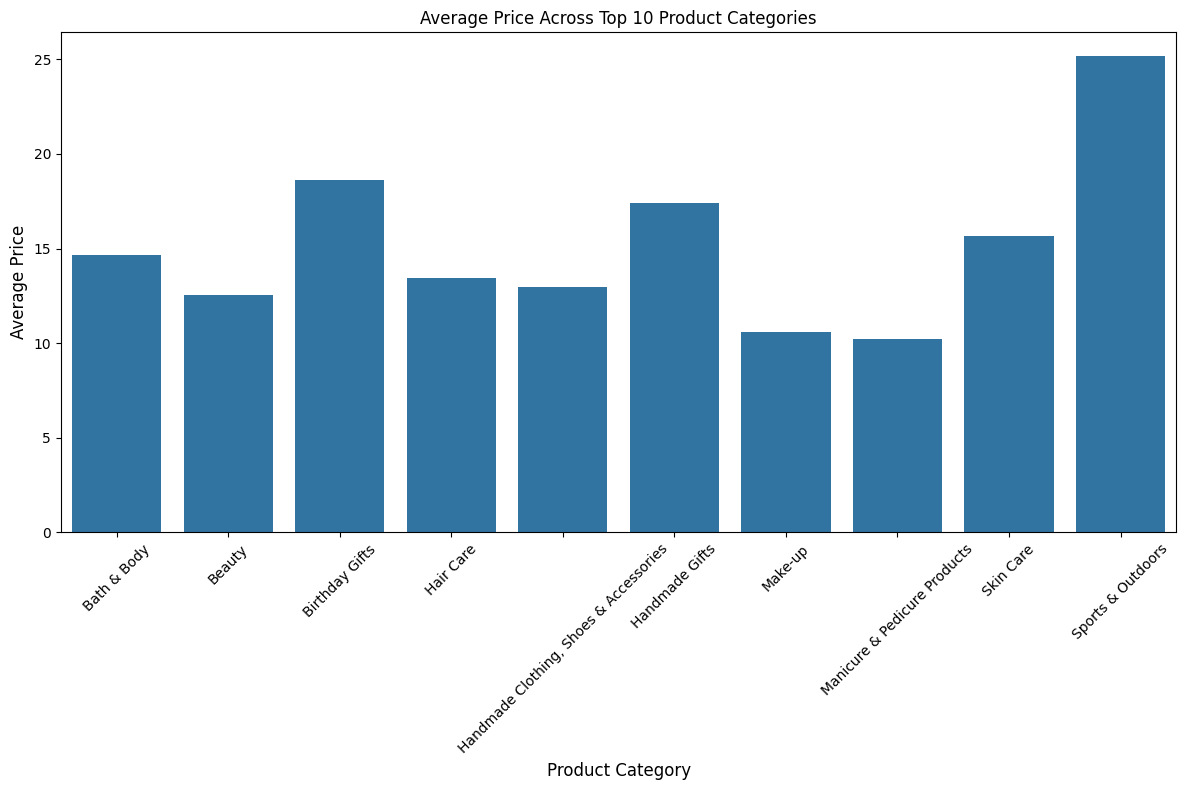

category    Desktop PCs
price              74.0
Name: 75, dtype: object

Category with highest median price: Desktop PCs with median price of 74.0



In [8]:
# 2. Bar Charts
# --------------------
# Create a bar chart comparing the average price of products for the top 10 product categories (based on count)
top_10_categories = df_filtered['category'].value_counts().nlargest(10).reset_index(name='count')
avg_prices = df_filtered[df_filtered['category'].isin(top_10_categories['category'])].groupby('category')['price'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='category', y='price', data=avg_prices, order=avg_prices['category'])
plt.xticks(rotation=45)
plt.title('Average Price Across Top 10 Product Categories')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.tight_layout()
plt.show()

# 2.2 Which product category commands the highest average price? Don't filter here by top categories
median_prices = df_filtered.groupby('category')['price'].median().reset_index()
highest_median_category = median_prices.loc[median_prices['price'].idxmax()]
display(highest_median_category)
print(f"Category with highest median price: {highest_median_category['category']} with median price of {highest_median_category['price']}\n")
# The category with the highest median price indicates that products in this category are generally more expensive compared to others.


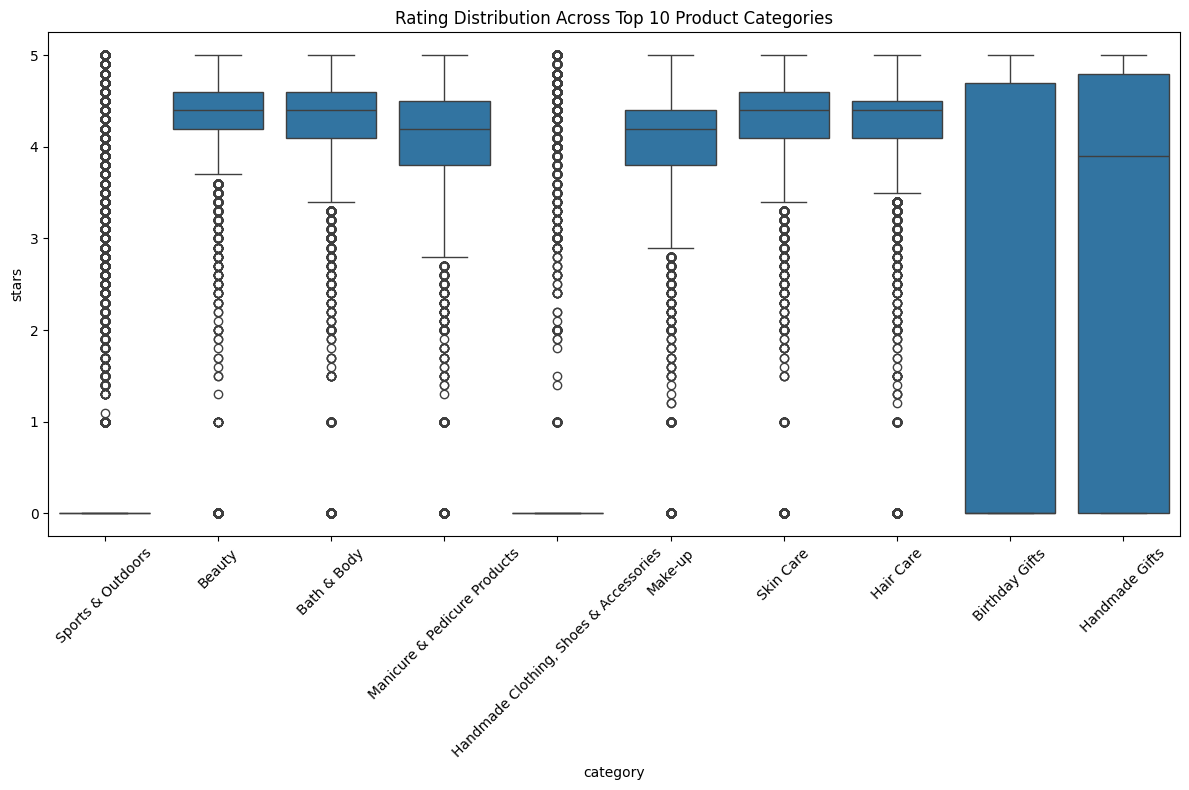

category    Computer Memory
stars                   4.7
Name: 56, dtype: object

Category with highest median rating: Computer Memory with median rating of 4.7



In [9]:
# 3. Box Plots
# --------------------
# 3.1 Visualize the distribution of product "ratings" based on their "category" using side-by-side box plots (Filter out the top 10 categories based on count for better visualization)
top_10_categories = df_filtered['category'].value_counts().nlargest(10).reset_index(name='count')
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='stars',
			data=df_filtered[df_filtered['category'].isin(top_10_categories['category'])],
			order=top_10_categories['category'])
plt.xticks(rotation=45)
plt.title('Rating Distribution Across Top 10 Product Categories')
plt.tight_layout()
plt.show()

# 3.1 Which category tends to receive the highest median rating from customers? Don't filter here by top categories
median_ratings = df_filtered.groupby('category')['stars'].median().reset_index()
highest_median_category = median_ratings.loc[median_ratings['stars'].idxmax()]
display(highest_median_category)
print(f"Category with highest median rating: {highest_median_category['category']} with median rating of {highest_median_category['stars']}\n")
# The category with the highest median rating indicates that products in this category are generally more favorably reviewed compared to others.

### Part 3: Investigating the Interplay Between Product Prices and Ratings

#### Objective: Analyze how product ratings ("stars") correlate with product prices

In [10]:
# 1. Correlation Coefficients
# --------------------
# 1.1 Calculate the correlation coefficient between "price" and "stars"
correlation, p_value = stats.pearsonr(df_filtered['price'], df_filtered['stars'])
print(f"Correlation Coefficient between Price and Stars: {correlation} \n")

# 1.2 Is there a significant correlation between product price and its rating
if correlation > 0:
    print("There is a positive correlation: as price increases, ratings tend to increase.\n")
elif correlation < 0:
    print("There is a negative correlation: as price increases, ratings tend to decrease.\n")
else:
    print("No correlation between price and ratings.\n")

Correlation Coefficient between Price and Stars: -0.07767299878153014 

There is a negative correlation: as price increases, ratings tend to decrease.



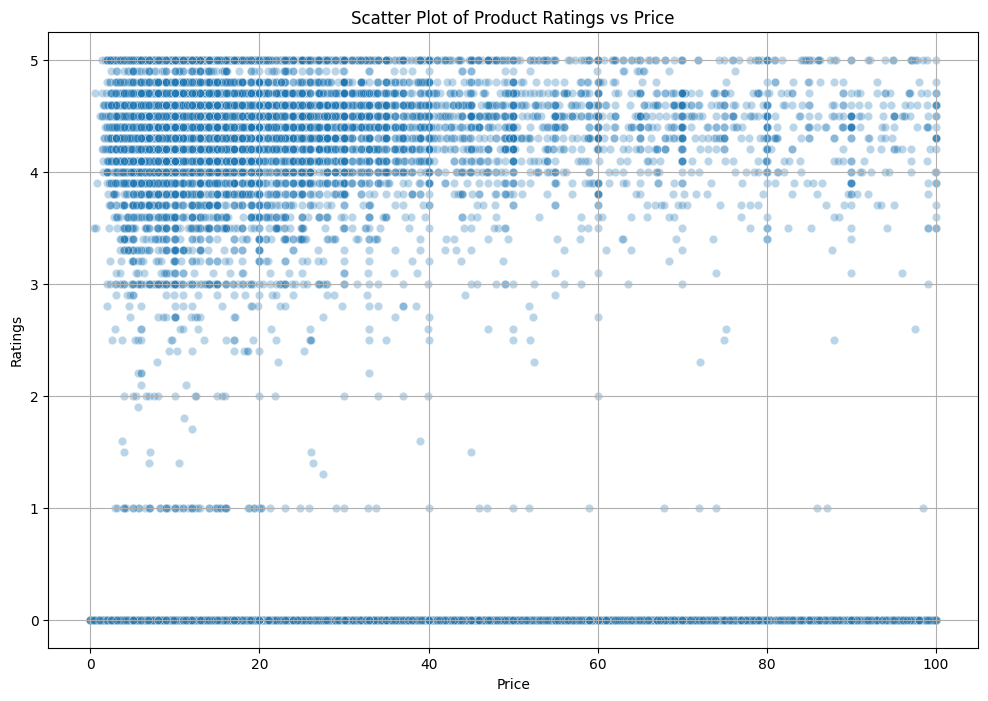

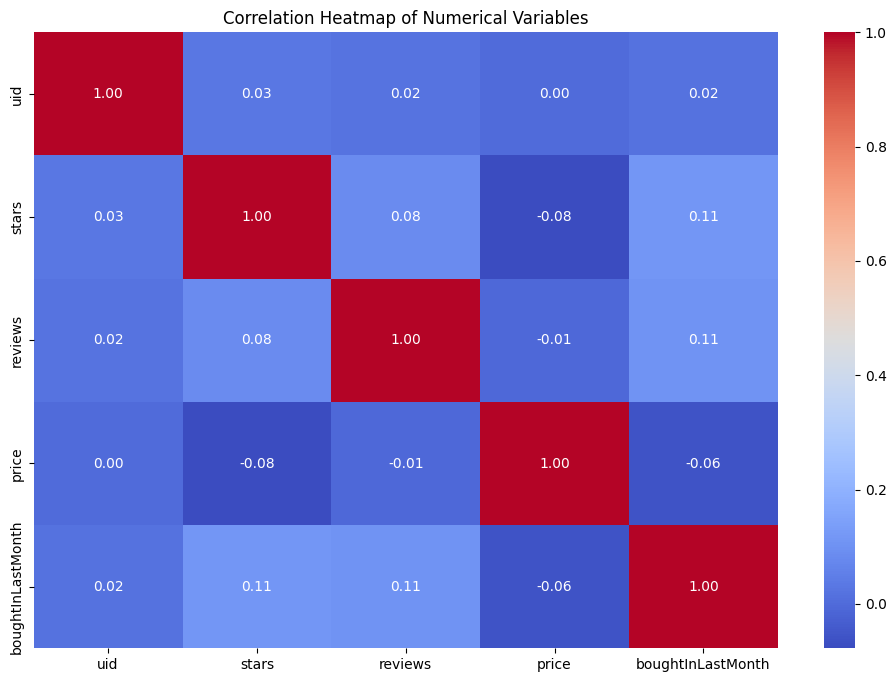

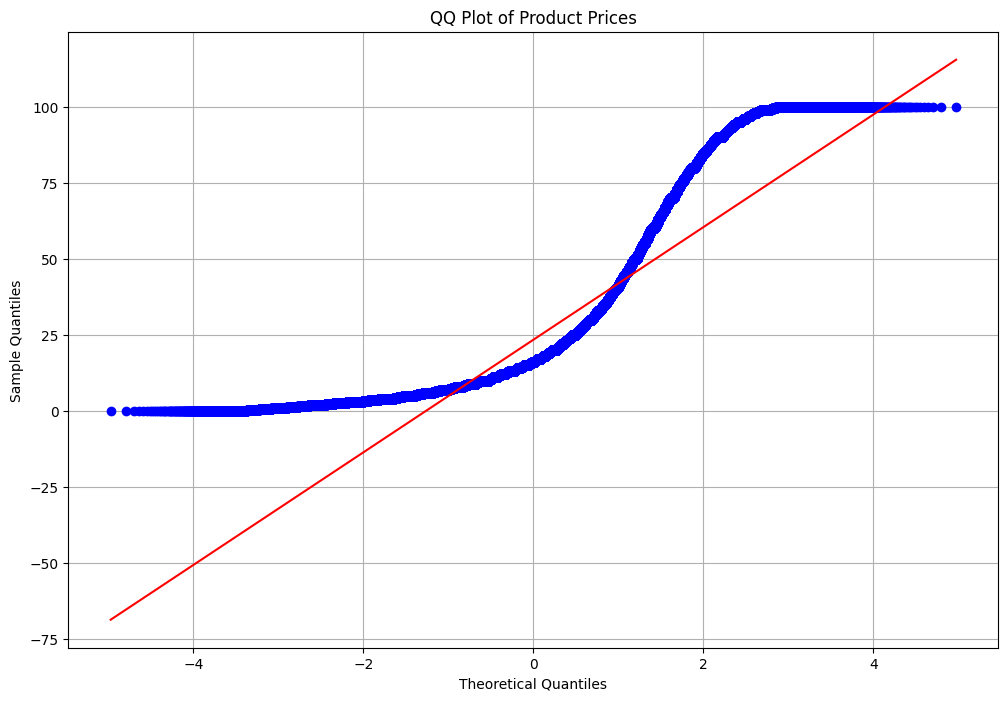

In [11]:
# 2. Visualizations
# --------------------
# Ensure the columns used for plotting are numeric and free of non-numeric values
# (sometimes object columns sneak in or there are bad values that cause conversion errors)
df_plot = df_filtered[['price', 'stars']].copy()
df_plot['price'] = pd.to_numeric(df_plot['price'], errors='coerce')
df_plot['stars'] = pd.to_numeric(df_plot['stars'], errors='coerce')
df_plot = df_plot.dropna(subset=['price', 'stars'])

# 2.1 Use a scatter plot to visualize the relationship between product rating and price
plt.figure(figsize=(12, 8))
# sample if the dataset is very large to keep the plot responsive
if len(df_plot) > 20000:
	plot_data = df_plot.sample(n=20000, random_state=42)
else:
	plot_data = df_plot
sns.scatterplot(x='price', y='stars', data=plot_data, alpha=0.3)
plt.title('Scatter Plot of Product Ratings vs Price')
plt.xlabel('Price')
plt.ylabel('Ratings')
plt.grid(True)
plt.show()

# Observations:
# From the scatter plot, we can observe that there is a slight trend (if any)
# between price and ratings, but the relationship appears weak and noisy.

# 2.2 Use a correlation heatmap to visualize correlations between all numerical variables
plt.figure(figsize=(12, 8))
numeric_df = df_filtered.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

# 2.3 Examine if product prices typically follow a normal distribution using a QQ plot
plt.figure(figsize=(12, 8))
stats.probplot(df_filtered['price'].dropna(), dist="norm", plot=plt)
plt.title('QQ Plot of Product Prices')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()